In [1]:
import os
import re

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf

if os.getcwd().split('/')[-1] == 'notebook':
    os.chdir('..')

from cma import CMA

In [2]:
tf.random.set_seed(444)

def fitness_fn(x):
    """
    Six-Hump Camel Function
    https://www.sfu.ca/~ssurjano/camel6.html
    """
    return (
        (4 - 2.1 * x[:,0]**2 + x[:,0]**4 / 3) * x[:,0]**2 +
        x[:,0] * x[:,1] +
        (-4 + 4 * x[:,1]**2) * x[:,1]**2
    )

In [3]:
def plot_six_hump_camel_fn(
    fitness_fn,
    xlim, 
    ylim,
    zlim=None,
    view_init=None, 
    mean=None, 
    solutions=None, 
    show_axes=False,
):
    a = np.linspace(*xlim, 100)
    b = np.linspace(*ylim, 100)
    y = lambda x1, x2: fitness_fn(np.array([[x1, x2]]))[0]

    A, B = np.meshgrid(a, b)
    zs = np.array([y(u, v) for u, v in zip(np.ravel(A), np.ravel(B))])
    Z = zs.reshape(A.shape)

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    if mean is not None:
        ax.scatter3D(
            [mean[0]], 
            [mean[1]], 
            [y(mean[0], mean[1])], 
            depthshade=False, 
            marker='+', 
            color='red',
            s=50,
        )

    if solutions is None:
        solutions = []
        
    for i, solution in enumerate(solutions):
        ax.scatter3D(
            [solution[0]], 
            [solution[1]], 
            [y(solution[0], solution[1])], 
            depthshade=False, 
            marker='o', 
            color='red' if (i+1) <= len(solutions) / 2 else 'grey',
            s=30,
        )

    ax.plot_surface(A, B, Z, cmap='cool', alpha=0.8)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(False)
    
    if zlim is not None:
        ax.set_zlim(zlim)
    
    if view_init is not None:
        ax.view_init(*view_init)
    
    if not show_axes:
        plt.axis('off')
        
    return fig, ax

In [4]:
cma = CMA(
    initial_solution=[1.7, -0.4],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
)

In [5]:
cma.search(12)

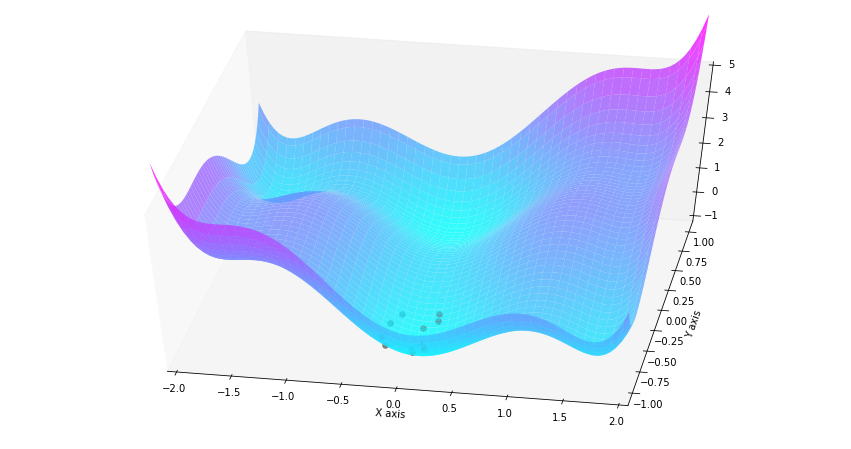

In [6]:
plot_six_hump_camel_fn(
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
    zlim=[-1.1, 5],
    view_init=[50, -80],
    mean=cma.best_solution(),
    solutions=cma.current_population.numpy(),
    show_axes=True,
);

In [7]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_radians(v1, v2):
    "in radians"
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [14]:
def plot_2d_contour(fitness_fn, xlim, ylim, mean=None, solutions=None, show_axes=False):
    a = np.linspace(*xlim, 100)
    b = np.linspace(*ylim, 100)
    y = lambda x1, x2: fitness_fn(np.array([[x1, x2]]))[0]

    A, B = np.meshgrid(a, b)
    zs = np.array([y(u, v) for u, v in zip(np.ravel(A), np.ravel(B))])
    Z = zs.reshape(A.shape)

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    if mean is not None:
        ax.plot(
            mean[0],
            mean[1],
            marker='+', 
            color='white',
            markersize=12,
            linestyle='None',
            label='mean',
        )

    if solutions is None:
        solutions = []
        
    mu = int(np.floor(len(solutions) / 2))
    for i, solution in enumerate(solutions):
        if i == 0:
            label = f'population (top {mu})'
        elif i == mu:
            label = f'population (bottom {mu})'
        else:
            label = None
        
        ax.plot(
            solution[0],
            solution[1],
            marker='o', 
            color='white',
            markersize=8 if (i+1) <= len(solutions) / 2 else 5,
            linestyle='None',
            markeredgecolor='grey' if (i+1) <= len(solutions) / 2 else None,
            label=label
        )

    cs = ax.contourf(A, B, Z, levels=25, cmap='cool')
    f.colorbar(cs, ax=ax)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)    
    ax.grid(False)
    
    if mean is not None or solutions is not None:
        ax.legend()
    
    if not show_axes:
        plt.axis('off')
        
    return fig, ax

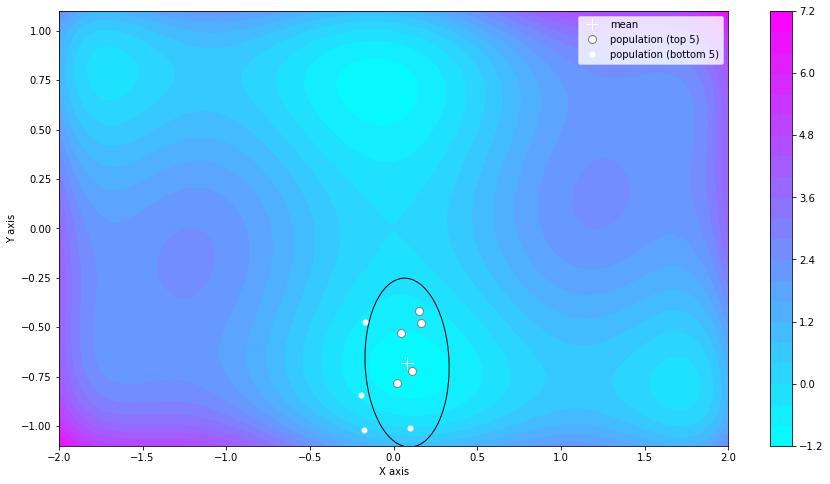

In [15]:
f, ax = plot_2d_contour(
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
    mean=cma.best_solution(),
    solutions=cma.current_population.numpy(),
    show_axes=True,
);

m = cma.best_solution()
B = cma.B.numpy()  # eigenvectors
l = (cma.σ**2 * cma._diag_D**2).numpy() # eigenvalues

angle = angle_radians([1, 0], B[1,:]) * (180 / np.pi)

confidence_95 = 5.991

ellipse = Ellipse(
    xy=(m[0], m[1]),
    width=2 * np.sqrt(confidence_95 * l[0]),
    height=2 * np.sqrt(confidence_95 * l[1]),
    angle=angle,
    facecolor='None', 
    edgecolor='black'
)

ax.add_patch(ellipse);